In [2]:
import torch, torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import utils

num_steps = 25 # number of time steps
batch_size = 1
beta = 0.5  # neuron decay rate
spike_grad = surrogate.fast_sigmoid() # surrogate gradient

net = nn.Sequential(
      nn.Conv2d(1, 8, 5),
      nn.MaxPool2d(2),
      snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad),
      nn.Conv2d(8, 16, 5),
      nn.MaxPool2d(2),
      snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad),
      nn.Flatten(),
      nn.Linear(16 * 4 * 4, 10),
      snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad, output=True)
      )

data_in = torch.rand(num_steps, batch_size, 1, 28, 28) # random input data
spike_recording = [] # record spikes over time
utils.reset(net) # reset/initialize hidden states for all neurons

for step in range(num_steps): # loop over time
    spike, state = net(data_in[step]) # one time step of forward-pass
    spike_recording.append(spike) # record spikes in list

In [3]:
from torchview import draw_graph

graph = draw_graph(net, input_size=(1, 1, 28, 28), expand_nested=True)
graph.visual_graph.render(
    filename="snn_graph",     # ohne Dateiendung
    directory=".",            # aktuelles Verzeichnis
    format="png",
    cleanup=True
)


'snn_graph.png'

In [4]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes
# Torch Variables
dtype = torch.float
from torchvision import datasets, transforms
# Define a transform to normalize the data
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [5]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [7]:
# Temporal Dynamics
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])
The output is spiking 50.00% of the time.


In [8]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 43.00% of the time.


In [9]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 47.00% of the time.


In [10]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

In [11]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [12]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


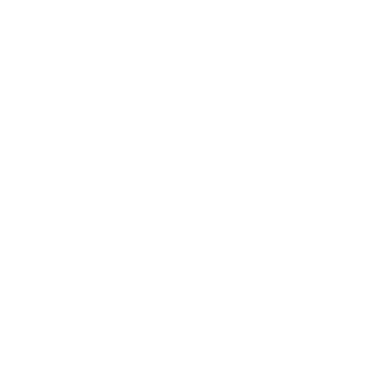

In [14]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [15]:
# If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
anim.save("spike_mnist_test.mp4")

In [16]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 0


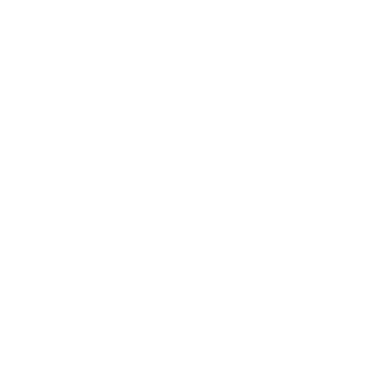

In [17]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

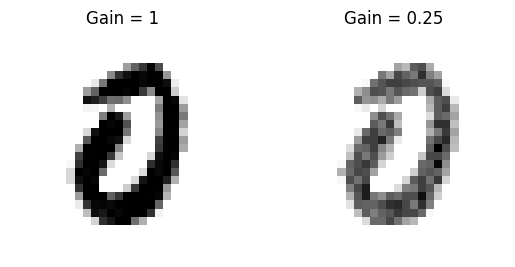

In [18]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

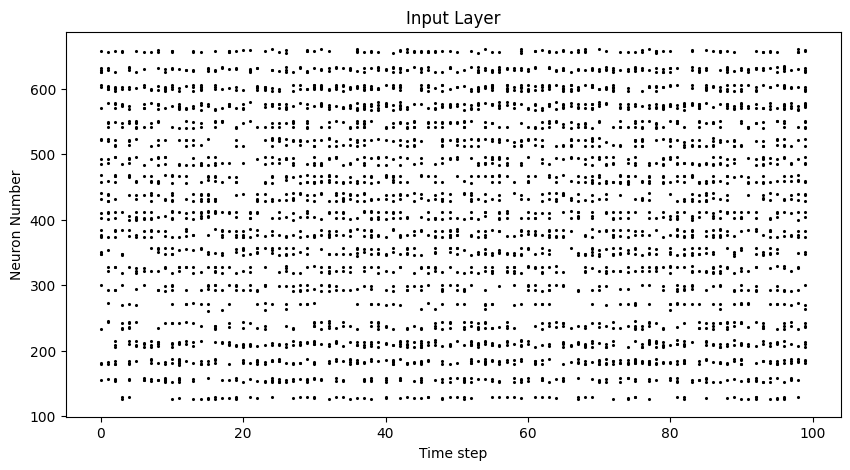

In [19]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

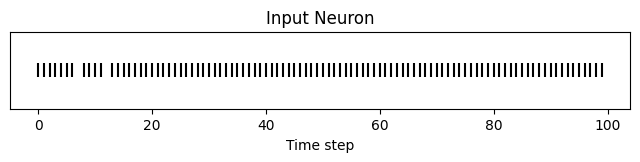

In [20]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

In [21]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time 

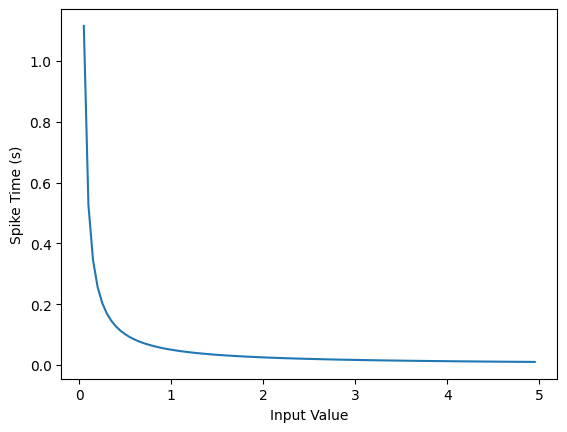

In [22]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

In [23]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

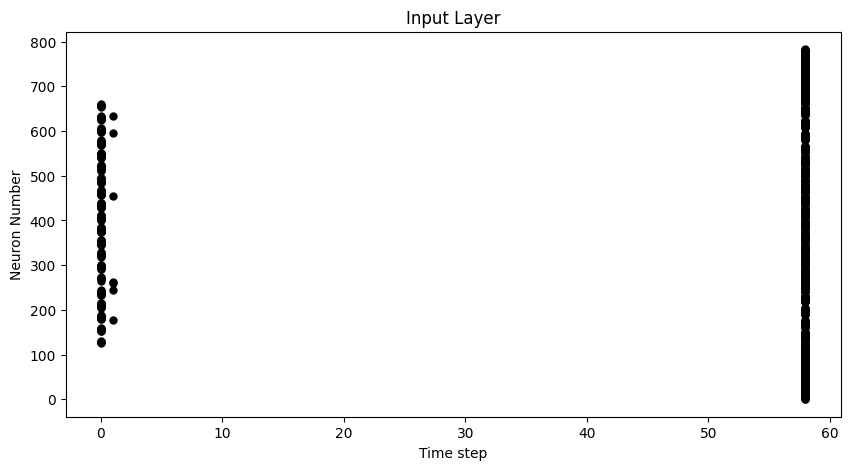

In [24]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

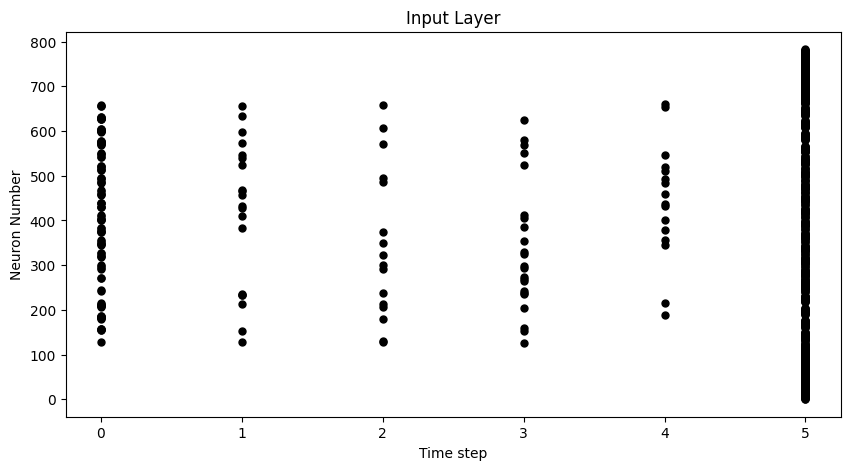

In [25]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

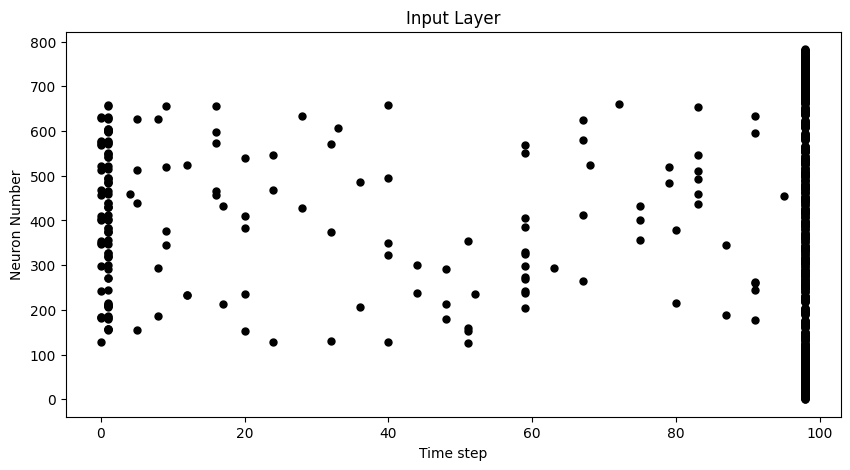

In [26]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

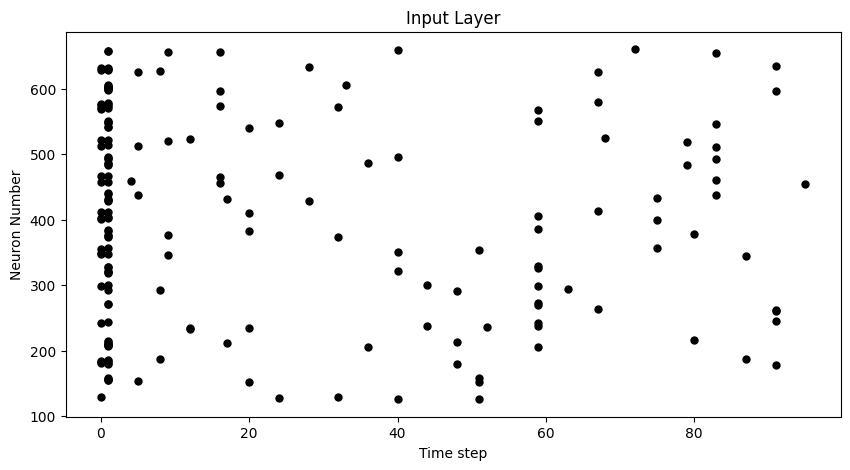

In [27]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, 
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [28]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


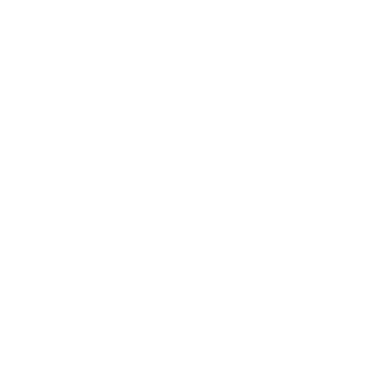

In [29]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())